In [56]:
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_ACCEL = 0.01  # drag constant

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action,  low_b_noise, up_b_noise):
        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        """
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust and drag
        delta_state = (DRAG_ACCEL - BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action

        # Noise
        noise_x = t.tensor([1, 0]) * t.tensor(np.random.uniform(low_b_noise, up_b_noise, 1))
        noise_v = t.tensor([0, 1]) * t.tensor(np.random.uniform(low_b_noise, up_b_noise, 1))
        noise = noise_x+noise_v

        # Update velocity
        state = state + delta_state + delta_state_gravity

        # Update state
        step_mat = t.tensor([[1., FRAME_TIME],
                             [0., 1.]])
      
        state = t.matmul(state, step_mat) + noise.float()
      
        return state
    
    
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        # little linear network with ReLU for embeddings
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T,  low_b_noise, up_b_noise):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        #self.is_Noise = is_Noise
        self.low_b_noise = low_b_noise
        self.up_b_noise = up_b_noise

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action,  self.low_b_noise, self.up_b_noise)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = np.zeros((30, 2))
        for i in range(state.shape[0]):
            state[i][0] = np.random.uniform(1, 2.5, 1)
            state[i][1] = 0
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return t.mean(state ** 2)

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        print()

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)] for j in range(30)])
        for i in range(30):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
        plt.title('position and velocity of the rocket')
        plt.xlabel('Rocket Position')
        plt.ylabel('Rocket Velocity')
        plt.show()


[1] loss: 149.979
[2] loss: 148.166
[3] loss: 147.891
[4] loss: 147.506
[5] loss: 147.619
[6] loss: 147.363
[7] loss: 147.359
[8] loss: 147.234
[9] loss: 147.191
[10] loss: 147.126
[11] loss: 146.951
[12] loss: 146.871
[13] loss: 146.986
[14] loss: 146.897
[15] loss: 146.834
[16] loss: 146.946
[17] loss: 146.866
[18] loss: 146.906
[19] loss: 146.920
[20] loss: 146.906
[21] loss: 146.958
[22] loss: 146.906
[23] loss: 146.912
[24] loss: 146.959
[25] loss: 146.980
[26] loss: 146.841
[27] loss: 146.844
[28] loss: 146.965
[29] loss: 146.970
[30] loss: 146.894
[31] loss: 146.879
[32] loss: 146.936
[33] loss: 146.888
[34] loss: 146.832
[35] loss: 146.933
[36] loss: 146.973
[37] loss: 146.839
[38] loss: 146.884
[39] loss: 146.958
[40] loss: 146.858


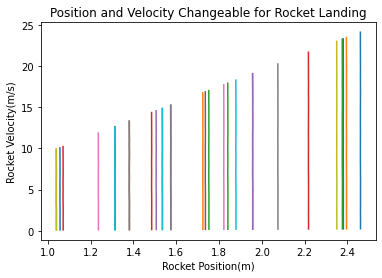

In [57]:
T = 100  # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
low_b_noise, up_b_noise = (-1e-4, 1e-4)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T,  low_b_noise, up_b_noise)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)